<a href="https://colab.research.google.com/github/yumehara/hackday_2022/blob/main/notebooks/all_city_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 市区町村別の項目別スコア

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install -q japanize-matplotlib

import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 100)

In [6]:
DIR_NAME = '/content/drive/MyDrive/hackday/'

## 市区町村ごとの歳出データ
- [令和4年版地方財政白書](https://www.soumu.go.jp/menu_seisaku/hakusyo/chihou/r04data/2022data/r04czb01-04.html)

In [7]:
df_expenditure = pd.read_csv(os.path.join(DIR_NAME, 'intermediate/expenditure.csv'))
print(df_expenditure.shape)

(1741, 94)


### RESASの人口ピラミッド

In [8]:
df_population = pd.read_csv(os.path.join(DIR_NAME, 'intermediate/population_pyramid.csv'))
print(df_population.shape)

(1682, 23)


### e-Stat (教育, 治安, 環境, 医療）

In [9]:
df_estat = pd.read_csv(os.path.join(DIR_NAME, 'intermediate/e_stat_data.csv'))
df_estat = df_estat.rename(columns={'地域 コード': '団体コード'})
df_estat = df_estat.drop(columns=[
    '地域',
    # 以下は、データが古いため除外
    'H6101_小売店数（事業所・企業統計調査結果）【事業所】_2006年度',
    'H6102_飲食店数（事業所・企業統計調査結果）【事業所】_2006年度',
    'A1101_総人口【人】_2015年度',
    'A1301_15歳未満人口【人】_2015年度',
    'A1302_15〜64歳人口【人】_2015年度',
    'A1303_65歳以上人口【人】_2015年度',
])
print(df_estat.shape)

(1741, 42)


### 高齢者施設

In [10]:
df_elderly_care = pd.read_csv(os.path.join(DIR_NAME, 'input/elderly_care.csv'))
print(df_elderly_care.shape)
df_elderly_care.columns = ['地域', 
    '介護老人福祉施設_施設数', '介護老人福祉施設_定員', '介護老人福祉施設_従事者数',
    '介護老人保健施設_施設数', '介護老人保健施設_定員', '介護老人保健施設_従事者数', 
    '介護療養型医療施設_施設数', '介護療養型医療施設_定員', '介護療養型医療施設_従事者数']
area_code = df_elderly_care['地域']
df_elderly_care = df_elderly_care.drop(columns=['地域']).replace('-', np.NaN).fillna(0).astype(int)
df_elderly_care['団体コード'] = area_code.apply(lambda x: x.split()[0]).astype(int)
df_elderly_care['市区町村名'] = area_code.apply(lambda x: x.split()[1])

(1964, 10)


## 全て結合

In [11]:
# 歳出 + 人口
df_city_feature = pd.merge(df_expenditure, df_population.drop(columns=['都道府県名', '市区町村名']), on='団体コード', how='left')
# + e-stat
df_city_feature = pd.merge(df_city_feature, df_estat, on='団体コード', how='left')
# + 高齢者施設
df_city_feature = pd.merge(df_city_feature, df_elderly_care.drop(columns=['市区町村名']), on='団体コード', how='left')
print(df_city_feature.shape)

(1741, 164)


### スコア

In [12]:
df_score = df_city_feature[['都道府県名', '市区町村名', '団体コード']].copy()

In [13]:
def normalize_score(sr_data, high=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    high = score.quantile(0.99)
    low = score.quantile(0.01)
    score[score > high] = high
    score[score < low] = low
    
    return (score - low)/(high - low)

In [14]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

### 人口分布

In [15]:
df_city_feature['幼児人口'] = (df_city_feature['0～4歳'] * 4/5 + df_city_feature['5～9歳'] * 2/5).round()
df_city_feature['小学生人口'] = (df_city_feature['5～9歳'] * 3/5 + df_city_feature['10～14歳'] * 3/5).round()
df_city_feature['中学生人口'] = (df_city_feature['10～14歳'] * 2/5 + df_city_feature['15～19歳'] * 1/5).round()

# 年少人口（15歳未満）
df_city_feature['年少人口'] = df_city_feature['0～4歳'] + df_city_feature['5～9歳'] + df_city_feature['10～14歳']
# 生産年齢人口（15歳以上65歳未満）
df_city_feature['生産年齢人口'] = (df_city_feature['15～19歳'] + df_city_feature['20～24歳'] + df_city_feature['25～29歳'] + df_city_feature['30～34歳'] + 
                                df_city_feature['35～39歳'] + df_city_feature['40～44歳'] + df_city_feature['45～49歳'] + df_city_feature['50～54歳'] + 
                                df_city_feature['55～59歳'] + df_city_feature['60～64歳'])
# 老年人口(65歳以上)
df_city_feature['老年人口'] = (df_city_feature['65～69歳'] + df_city_feature['70～74歳'] + df_city_feature['75～79歳'] + df_city_feature['80～84歳'] + 
                                df_city_feature['85～89歳'] + df_city_feature['90歳～'])

# 年少人口指数 = 年少人口/生産年齢人口×100
df_city_feature['年少人口指数'] = df_city_feature['年少人口'] / df_city_feature['生産年齢人口'] * 100
# 老年人口指数 = 老年人口/生産年齢人口×100
df_city_feature['老年人口指数'] = df_city_feature['老年人口'] / df_city_feature['生産年齢人口'] * 100
# 従属人口指数 = (年少人口＋老年人口)/生産年齢人口×100
df_city_feature['従属人口指数'] = (df_city_feature['年少人口'] + df_city_feature['老年人口']) / df_city_feature['生産年齢人口'] * 100
# 老年化指数 = 老年人口/年少人口×100
df_city_feature['老年化指数'] = df_city_feature['老年人口'] / df_city_feature['年少人口'] * 100

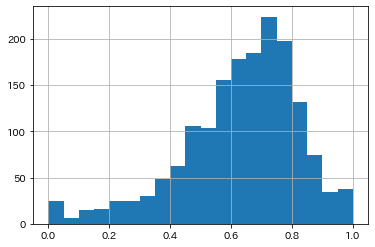

In [16]:
score_list = [
    normalize_score(df_city_feature['年少人口指数'], True) * 0.3,
    normalize_score(df_city_feature['老年人口指数'], False) * 0.3,
    normalize_score(df_city_feature['老年化指数'], False) * 0.4,
]
df_score['人口分布スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_score['人口分布'] = rank_score(df_score['人口分布スコア'])
df_score['人口分布スコア'].hist(bins=20)

### 財政

In [17]:
df_city_feature['人口一人当たりの歳出合計'] = df_city_feature['001:歳出合計'] / df_city_feature['人口']
df_city_feature['人口一人当たりの一般財源'] = df_city_feature['D2209_一般財源（市町村財政）【千円】_2019年度'] / df_city_feature['人口']
df_city_feature['公債費比率'] = df_city_feature['023:公債費'] / df_city_feature['D2209_一般財源（市町村財政）【千円】_2019年度'] * 100
df_city_feature['人口一人当たりの人件費'] = df_city_feature['D320401_人件費（市町村財政）【千円】_2019年度'] / df_city_feature['人口']

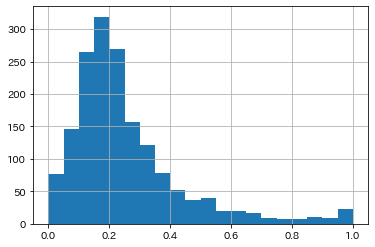

In [18]:
score_list = [
    normalize_score(df_city_feature['人口一人当たりの歳出合計'], True) * 0.3,
    normalize_score(df_city_feature['人口一人当たりの一般財源'], True) * 0.3,
    normalize_score(df_city_feature['公債費比率'], False) * 0.2,
    normalize_score(df_city_feature['人口一人当たりの人件費'], False) * 0.2,
    # normalize_score(df_city_feature['D2201_財政力指数（市町村財政）【‐】_2019年度'], True),       # 東京都特別区のデータがないため除外
    # normalize_score(df_city_feature['D2204_公債費比率（市町村財政）【％】_2007年度'], False),      # 東京都特別区のデータがないため除外
    # normalize_score(df_city_feature['D2202_実質収支比率（市町村財政）【％】_2019年度'], True),     # 東京都特別区のデータがないため除外
]
df_score['財政スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_score['財政'] = rank_score(df_score['財政スコア'])
df_score['財政スコア'].hist(bins=20)

### 教育

In [19]:
df_city_feature['少年一人当たりの教育費総額'] = df_city_feature['002:教育費・総額'] / df_city_feature['年少人口']
df_city_feature['少年一人当たりの保健体育・給食費'] = df_city_feature['011:教育費・保健体育費・学校給食費'] / df_city_feature['年少人口']
df_city_feature['幼児一人当たりの幼稚園費'] = df_city_feature['008:教育費・幼稚園費'] / df_city_feature['幼児人口']
df_city_feature['小学生一人当たりの小学校費'] = df_city_feature['004:教育費・小学校費'] / df_city_feature['小学生人口']
df_city_feature['中学生一人当たりの中学校費'] = df_city_feature['005:教育費・中学校費'] / df_city_feature['中学生人口']

df_city_feature['教員一人当たりの小学校児童数'] = df_city_feature['E2501_小学校児童数【人】_2020年度'] / df_city_feature['E2401_小学校教員数【人】_2020年度']
df_city_feature['教員一人当たりの中学校生徒数'] = df_city_feature['E3501_中学校生徒数【人】_2020年度'] / df_city_feature['E3401_中学校教員数【人】_2020年度']
df_city_feature['幼児人口千人当たりの幼稚園数'] = df_city_feature['E1101_幼稚園数【園】_2020年度'] / df_city_feature['幼児人口'] * 1000
df_city_feature['小学生人口千人当たりの小学校数'] = df_city_feature['E2101_小学校数【校】_2020年度'] / df_city_feature['小学生人口'] * 1000
df_city_feature['中学生人口千人当たりの中学校数'] = df_city_feature['E3101_中学校数【校】_2020年度'] / df_city_feature['中学生人口'] * 1000

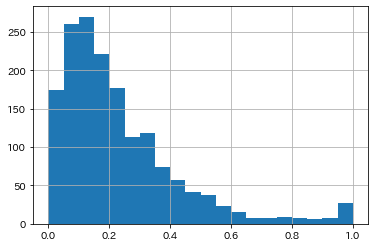

In [20]:
score_list = [
    normalize_score(df_city_feature['少年一人当たりの教育費総額'], True) * 0.2,
    normalize_score(df_city_feature['少年一人当たりの保健体育・給食費'], True) * 0.1,
    normalize_score(df_city_feature['幼児一人当たりの幼稚園費'], True) * 0.1,
    normalize_score(df_city_feature['小学生一人当たりの小学校費'], True) * 0.1,
    normalize_score(df_city_feature['中学生一人当たりの中学校費'], True) * 0.1,

    normalize_score(df_city_feature['教員一人当たりの小学校児童数'], False) * 0.05,
    normalize_score(df_city_feature['教員一人当たりの中学校生徒数'], False) * 0.05,
    normalize_score(df_city_feature['幼児人口千人当たりの幼稚園数'], True) * 0.05,
    normalize_score(df_city_feature['小学生人口千人当たりの小学校数'], True) * 0.05,
    normalize_score(df_city_feature['中学生人口千人当たりの中学校数'], True) * 0.05,
]

df_score['教育スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_score['教育'] = rank_score(df_score['教育スコア'])
df_score['教育スコア'].hist(bins=20)

### 社会福祉

In [21]:
df_city_feature['人口一人当たりの民生費総額'] = df_city_feature['001:民生費・総額'] / df_city_feature['人口']
df_city_feature['少年一人当たりの児童福祉費'] = df_city_feature['004:民生費・児童福祉費'] / df_city_feature['年少人口']
df_city_feature['老人一人当たりの老人福祉費'] = df_city_feature['003:民生費・老人福祉費'] / df_city_feature['老年人口']
df_city_feature['幼児人口千人当たりの保育所数'] = df_city_feature['J250302_保育所等数（基本票）【所】_2019年度'] / df_city_feature['幼児人口'] * 1000
df_city_feature['幼児人口一人当たりの保育児童数'] = df_city_feature['J2506_保育所等在所児数（詳細票）【人】_2017年度'] / df_city_feature['幼児人口']

for col1 in ['介護老人福祉施設', '介護老人保健施設', '介護療養型医療施設']:
    for col2 in ['施設数', '定員', '従事者数']:
        df_city_feature[f'老人千人当たりの{col1}_{col2}'] = df_city_feature[f'{col1}_{col2}'] / df_city_feature['老年人口'] * 1000

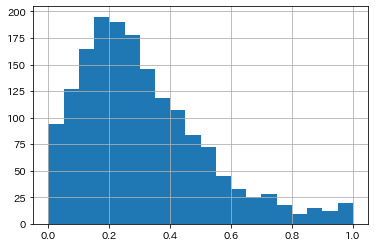

In [22]:
score_list = [
    normalize_score(df_city_feature['人口一人当たりの民生費総額'], True) * 0.3,
    normalize_score(df_city_feature['少年一人当たりの児童福祉費'], True) * 0.2,
    normalize_score(df_city_feature['老人一人当たりの老人福祉費'], True) * 0.1,
    normalize_score(df_city_feature['幼児人口千人当たりの保育所数'], True) * 0.1,
    normalize_score(df_city_feature['幼児人口一人当たりの保育児童数'], True) * 0.1,
]
for col1 in ['介護老人福祉施設', '介護老人保健施設', '介護療養型医療施設']:
    for col2 in ['施設数', '定員', '従事者数']:
        score_list.append(normalize_score(df_city_feature[f'老人千人当たりの{col1}_{col2}'], True) * 0.02)

df_score['社会福祉スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_score['社会福祉'] = rank_score(df_score['社会福祉スコア'])
df_score['社会福祉スコア'].hist(bins=20)

### 医療

In [23]:
df_city_feature['人口千人当たりの病院数'] = df_city_feature['I5101_病院数【施設】_2019年度'] / df_city_feature['人口'] * 1000
df_city_feature['人口千人人当たりの病床数'] = df_city_feature['I5211_病院病床数【床】_2019年度'] / df_city_feature['人口'] * 1000
df_city_feature['人口千人人当たりの医師数'] = df_city_feature['I6100_医師数【人】_2018年度'] / df_city_feature['人口'] * 1000
df_city_feature['人口千人人当たりの薬剤師数'] = df_city_feature['I6300_薬剤師数【人】_2018年度'] / df_city_feature['人口'] * 1000

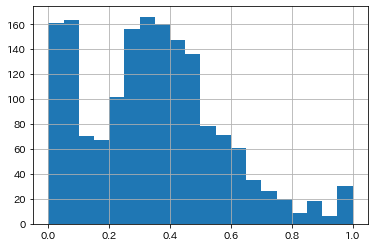

In [24]:
score_list = [
    normalize_score(df_city_feature['人口千人当たりの病院数'], True),
    normalize_score(df_city_feature['人口千人人当たりの病床数'], True),
    normalize_score(df_city_feature['人口千人人当たりの医師数'], True),
    normalize_score(df_city_feature['人口千人人当たりの薬剤師数'], True),
]
df_score['医療スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_score['医療'] = rank_score(df_score['医療スコア'])
df_score['医療スコア'].hist(bins=20)

### 治安

In [25]:
df_city_feature['人口千人当たりの交通事故件数'] = df_city_feature['K3101_交通事故発生件数【件】_2009年度'] / df_city_feature['人口'] * 1000
df_city_feature['人口千人当たりの刑法犯認知件数'] = df_city_feature['K4201_刑法犯認知件数【件】_2008年度'] / df_city_feature['人口'] * 1000

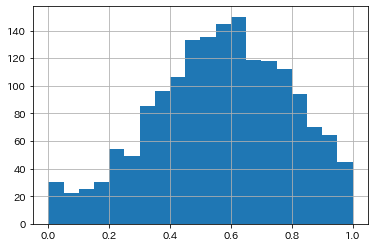

In [26]:
score_list = [
    normalize_score(df_city_feature['人口千人当たりの交通事故件数'], False),
    normalize_score(df_city_feature['人口千人当たりの刑法犯認知件数'], False),
]
df_score['治安スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_score['治安'] = rank_score(df_score['治安スコア'])
df_score['治安スコア'].hist(bins=20)

### 環境

In [27]:
df_city_feature['人口一人当たりの公園費'] = df_city_feature['007:土木費・都市計画費・公園費'] / df_city_feature['人口']
df_city_feature['人口一人当たりの可住地面積'] = df_city_feature['B1103_可住地面積【ｈａ】_2020年度'] / df_city_feature['人口']
df_city_feature['総面積当たりの森林面積'] = (
    df_city_feature['B1105_林野面積【ｈａ】_2014年度'] + 
    df_city_feature['B1106_森林面積【ｈａ】_2014年度'] + 
    df_city_feature['B1107_森林以外の草生地面積【ｈａ】_2014年度']
) / df_city_feature['B1101_総面積（北方地域及び竹島を除く）【ｈａ】_2020年度']
df_city_feature['人口一人当たりのごみ排出量'] = df_city_feature['H5609_ごみ総排出量（総量）【ｔ】_2019年度'] / df_city_feature['人口']

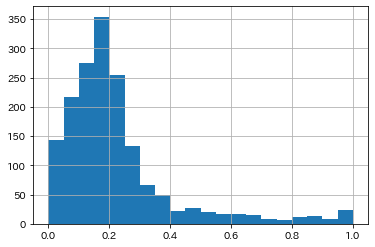

In [28]:
score_list = [
    normalize_score(df_city_feature['人口一人当たりの公園費'], True) * 0.4,
    normalize_score(df_city_feature['人口一人当たりの可住地面積'], True) * 0.4,
    normalize_score(df_city_feature['総面積当たりの森林面積'], True) * 0.1,
    # normalize_score(df_city_feature['人口一人当たりのごみ排出量'], True),     # 東京都特別区のデータがないため除外
]
df_score['環境スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_score['環境'] = rank_score(df_score['環境スコア'])
df_score['環境スコア'].hist(bins=20)

### 防災

In [29]:
df_city_feature['人口一人当たりの消防費'] = df_city_feature['001:消防費'] / df_city_feature['人口']
df_city_feature['人口一人当たりの災害救助費'] = df_city_feature['006:民生費・災害救助費'] / df_city_feature['人口']

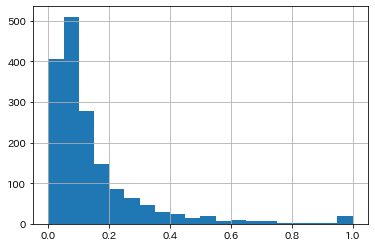

In [30]:
score_list = [
    normalize_score(df_city_feature['人口一人当たりの消防費'], True) * 0.8,
    normalize_score(df_city_feature['人口一人当たりの災害救助費'], True) * 0.2,
]
df_score['防災スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_score['防災'] = rank_score(df_score['防災スコア'])
df_score['防災スコア'].hist(bins=20)

### 総合

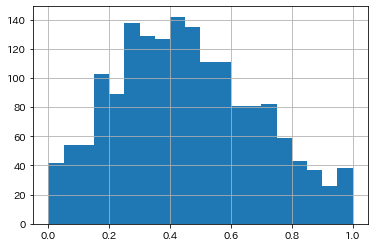

In [58]:
score_list = []
for col in ['人口分布', '財政', '教育', '社会福祉', '医療', '治安']:
    score_list.append(df_score[col])
for col in ['環境', '防災']:
    score_list.append(df_score[col]*0.3)

df_score['総合スコア'] = normalize_score(pd.concat(score_list, axis=1).mean(axis=1, skipna=True))
df_score['総合'] = rank_score(df_score['総合スコア'])
df_score['総合スコア'].hist(bins=20)

### 出力

In [59]:
OUTPUT_DIR = os.path.join(DIR_NAME, 'output')

In [60]:
df_city_all = pd.merge(df_score, df_city_feature, on=['都道府県名', '市区町村名', '団体コード'], how='outer')
print(df_city_all.shape)
assert len(df_city_all) == len(df_score)
assert len(df_city_all) == len(df_city_feature)

df_city_all.to_csv(os.path.join(OUTPUT_DIR, 'city_all.csv'), index=False)

(1741, 232)


In [61]:
print(df_city_feature.shape)
df_city_feature.to_csv(os.path.join(OUTPUT_DIR, 'city_feature.csv'), index=False)

print(df_score.shape)
df_score.to_csv(os.path.join(OUTPUT_DIR, 'city_score.csv'), index=False)

(1741, 214)
(1741, 21)


## 総合ランキング

In [62]:
rank_columns = [col for col in df_score.columns if not 'スコア' in col]
rank_columns.remove('団体コード')
print(rank_columns)

['都道府県名', '市区町村名', '人口分布', '財政', '教育', '社会福祉', '医療', '治安', '環境', '防災', '総合']


In [63]:
def draw_heatmap(df_score, top_n=10):
    height = int(top_n/2) + 1
    plt.figure(figsize = (12, height))
    sns.heatmap(df_score.set_index(['都道府県名', '市区町村名']).head(top_n), annot=True, fmt='1.2f', vmin=0, vmax=5, cmap='coolwarm')
    plt.show()

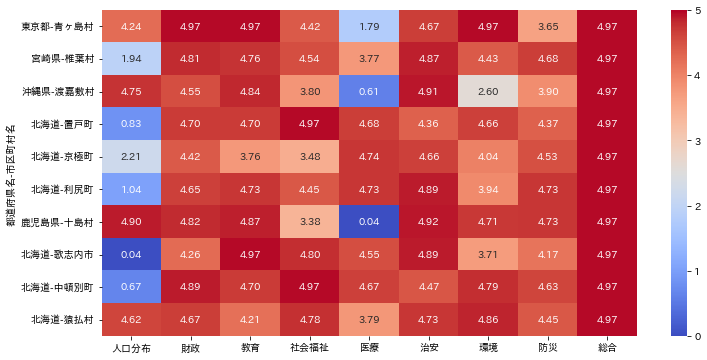

In [64]:
# ベスト10
draw_heatmap(df_score[rank_columns].sort_values('総合', ascending=False).reset_index(drop=True))

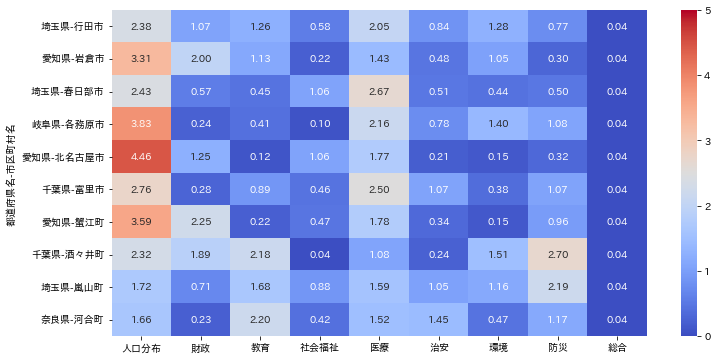

In [65]:
# ワースト10
draw_heatmap(df_score[rank_columns].sort_values('総合', ascending=True).reset_index(drop=True))

### 人口50万人以上の都市

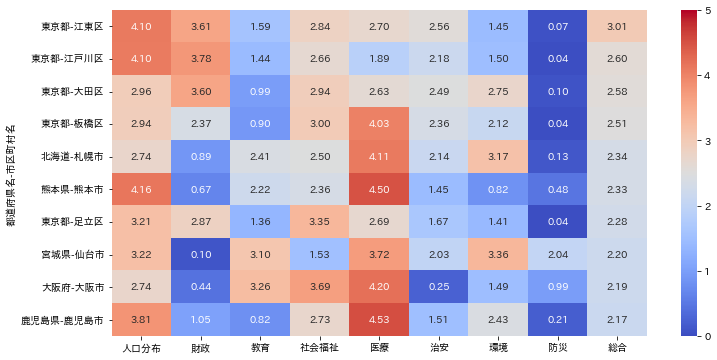

In [66]:
# ベスト10
draw_heatmap(df_city_all[df_city_all['人口'] > 500000][rank_columns].sort_values('総合', ascending=False).reset_index(drop=True))

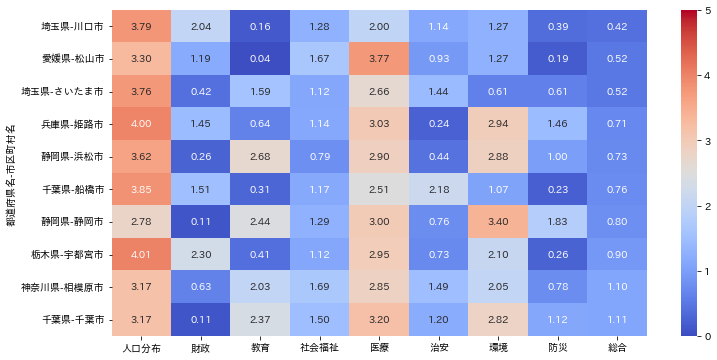

In [67]:
# ワースト10
draw_heatmap(df_city_all[df_city_all['人口'] > 500000][rank_columns].sort_values('総合', ascending=True).reset_index(drop=True))

### 大阪府内の市

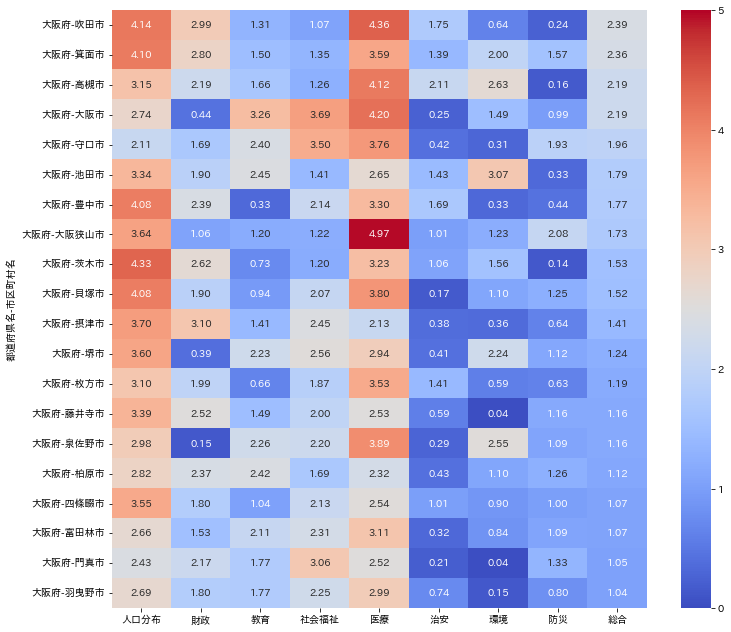

In [68]:
# 大阪府ベスト20
draw_heatmap(
    df_score[(df_score['都道府県名'] == '大阪府')&(df_score['市区町村名'].str.endswith('市'))][rank_columns].sort_values('総合', ascending=False).reset_index(drop=True),
    20
)

In [69]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["font.size"] = 14

In [70]:
def draw_bar_graph_by_city(df_data, col_name, x_col='市区町村名'):
    data = df_data.sort_values(col_name, ascending=False)[[x_col, col_name]]
    data.plot(x=x_col, kind='bar', title=col_name, figsize=(17, 5))
    mean = data[col_name].mean()
    plt.axhline(y=mean, xmin=0, xmax=1, color='red')
    plt.grid()
    plt.legend().remove()
    plt.show()

def draw_stacked_bar_graph_by_city(df_data, title, mean):
    df_data.plot(x='市区町村名', kind='bar', stacked=True, title=title, figsize=(17, 5))
    plt.axhline(y=mean, xmin=0, xmax=1, color='red')
    plt.grid()
    plt.show()

### 東京都(23区)と主要都市の比較

In [71]:
df_big_city = df_city_feature[
    ((df_city_feature['都道府県名'] == '東京都')&(df_city_feature['市区町村名'].str.endswith('区')))|
    (df_city_feature['市区町村名'].isin(['札幌市', 'さいたま市', '横浜市', '川崎市', '名古屋市', '大阪市', '京都市', '神戸市', '福岡市']))
]

#### 総合スコア

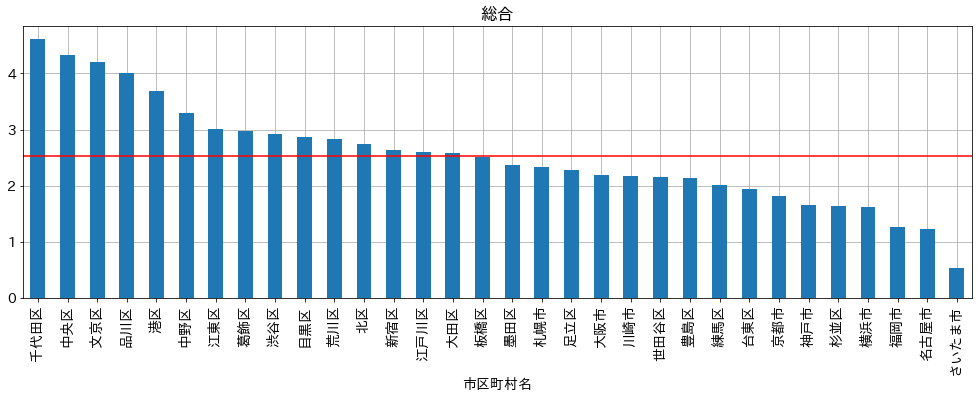

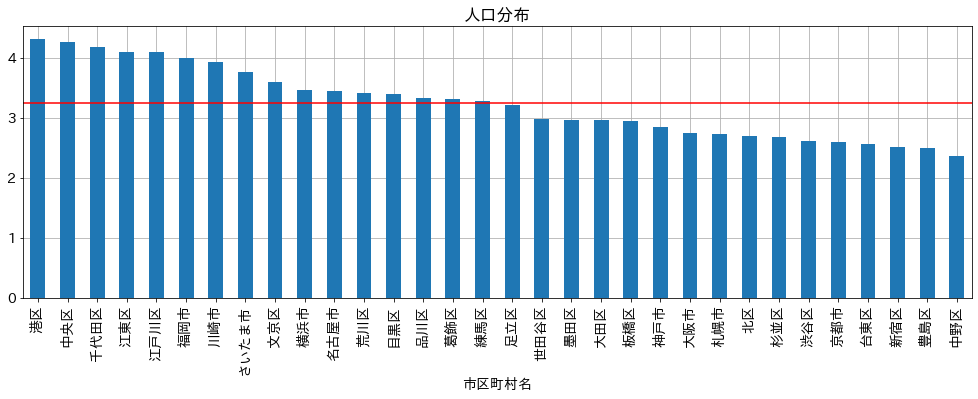

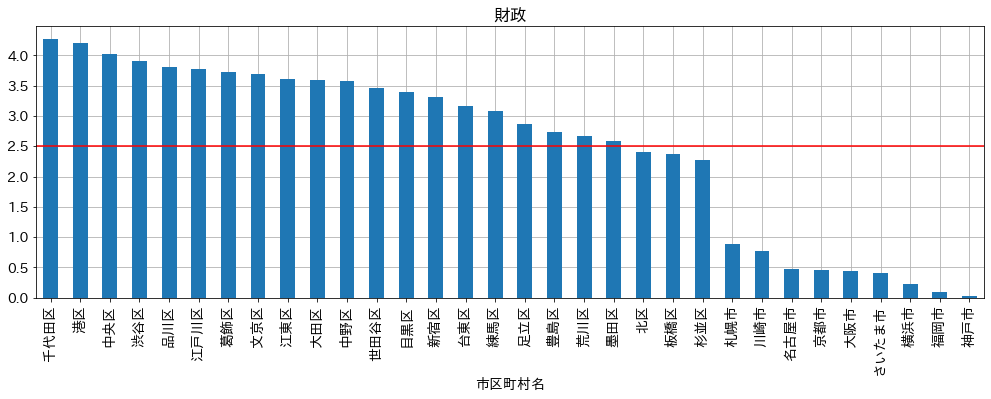

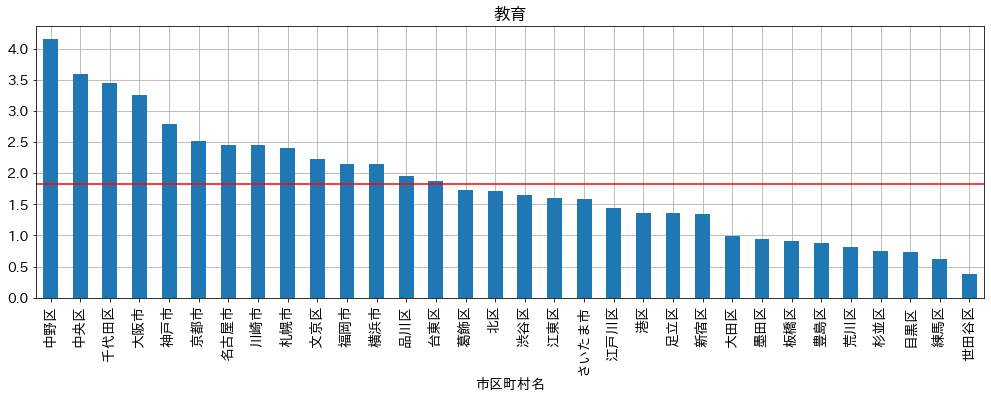

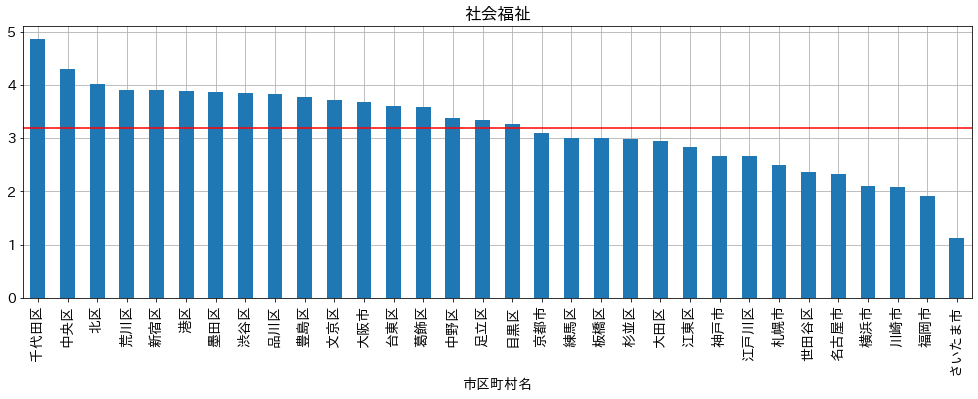

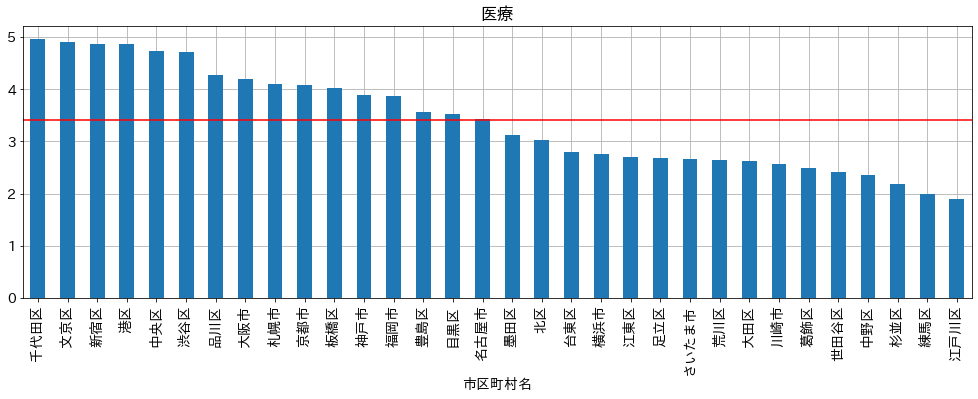

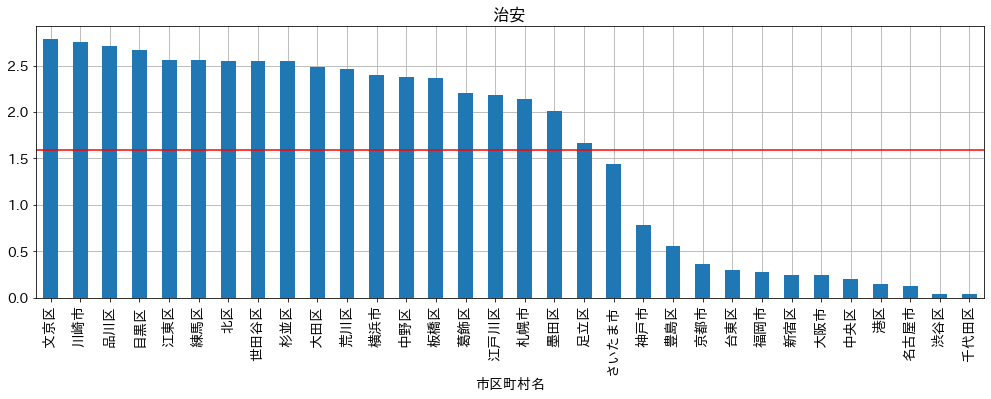

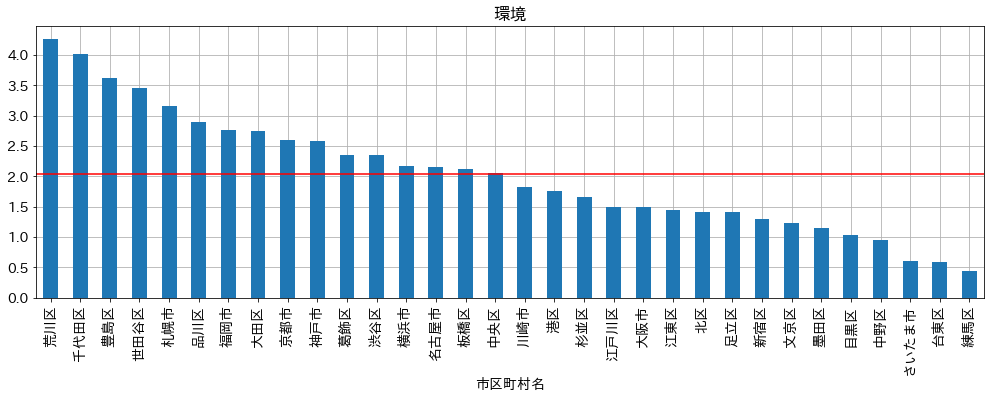

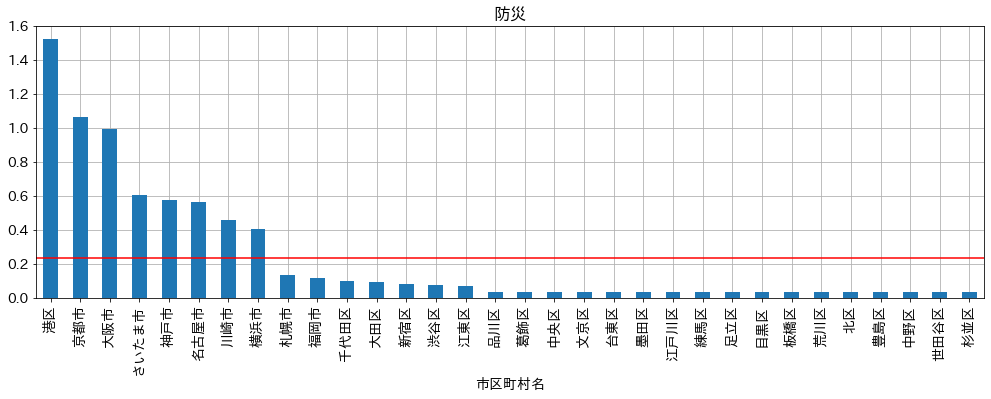

In [72]:
df_score_big_city = df_score[df_score['団体コード'].isin(df_big_city['団体コード'])]

for col in ['総合', '人口分布', '財政', '教育', '社会福祉', '医療', '治安', '環境', '防災']:
    draw_bar_graph_by_city(df_score_big_city, col)

In [73]:
subtotal_col = [col for col in list(df_expenditure.columns) if '総額' in col]
df_subtotal = df_expenditure[subtotal_col].sum().rename('歳出').sort_values(ascending=False)

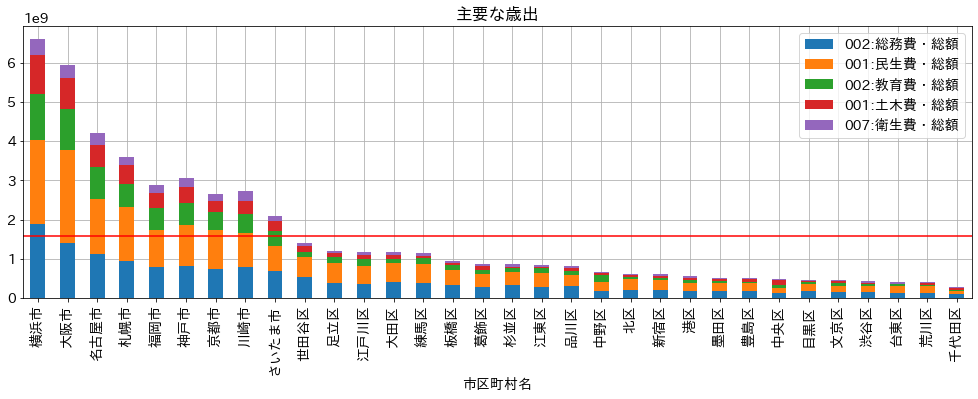

In [74]:
subtotal_top = list(df_subtotal.head(5).index)
draw_stacked_bar_graph_by_city(
    df_big_city.sort_values('001:歳出合計', ascending=False)[['市区町村名'] + subtotal_top],
    '主要な歳出',
    df_big_city[subtotal_top].sum(axis=1).mean()
)

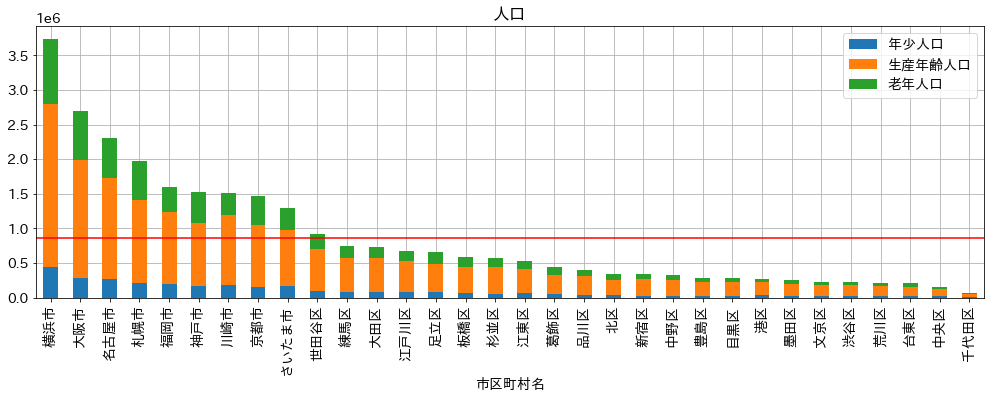

In [75]:
draw_stacked_bar_graph_by_city(
    df_big_city.sort_values('人口', ascending=False)[['市区町村名', '年少人口', '生産年齢人口', '老年人口']], '人口',
    df_big_city['人口'].mean()
)

### 人口指数

In [76]:
# for col in ['年少人口指数', '老年人口指数', '従属人口指数', '老年化指数']:
#     draw_bar_graph_by_city(df_big_city, col)

### 各種指標

In [77]:
# view_columns = [col for col in list(df_city_feature.columns) if '当たり' in col] + ['公債費比率']
# for col in view_columns:
#     draw_bar_graph_by_city(df_big_city, col)